### Lib and plot setting

In [50]:
import os
import numpy as np
import pandas as pd

import matplotlib.pylab as pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

params = {'legend.fontsize': 20,
          'figure.figsize': (8, 5),
         'axes.labelsize': 24,
         'axes.titlesize':16,
         'xtick.labelsize':18,
         'ytick.labelsize':18}

mpl.rc('font',family='Times New Roman')
pylab.rcParams.update(params)
cmap = plt.cm.viridis
count = 10
color = [cmap(round(i/count*cmap.N)) for i in range(count)]

### Data Import and preprocessing

/home/zhenzi/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


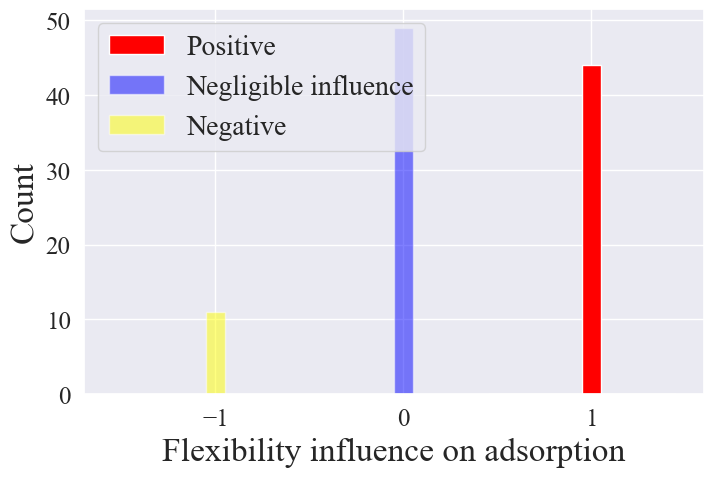

In [51]:
# Read all data

adsorbateList = ['ethane','ethene','propane','propene','butane','xe','kr']

df_ad = pd.DataFrame()
df_kh = pd.DataFrame()
df = pd.DataFrame()

for adsorbate in adsorbateList:
    temp = pd.read_csv( os.path.join( 'data/flex/ad_csv',adsorbate+'.csv') )
    temp['adsorbate'] = [adsorbate]*len(temp)
    temp_df = temp[['MOF','adsorbate','Relax','MCMD']]
    df = pd.concat([df,temp_df])

molData=np.array([
    ['xe',131.293,289.7,58.4,0.008,164.87,161.2,3.96], 
    ['butane',58.1,449.8,39.5,0.3,280.1,146.7,4.68], 
    ['propene',42.1,436.9,51.7,0.2,254.8,150.6,4.50], 
    ['ethane',30.1,381.8,50.3,0.2,184.0,126.2,4.44], 
    ['propane',44.1,416.5,44.6,0.2,230.1,136.5,4.30], 
    ['CO2',44.0,295.9,71.8,0.2,317.4,204.9,3.3], 
    ['ethene',28.054,282.5,51.2,0.089,169.3,228,4.16], 
    ['methane',16.04,190.4,46.0,0.011,111.5,91,3.80],
    ['kr',83.798,209.4,55.0,0.005,119.6,115.6,3.6]])

df_mol = pd.DataFrame(data=molData, columns=["adsorbate", "Mw/gr.mol-1", "Tc/K", "Pc/bar", "w", "Tb/K", "Tf/K",'d'])
temp = pd.read_csv('data/Data_S1.csv')
feature = temp[temp['molecule']=='ethane'][temp.columns[2:101]]
feature['MOF'] = temp[temp['molecule']=='ethane']['MOF']

megnet = pd.read_csv('data/megnet_properties.csv')
df = pd.merge(df,megnet,on='MOF')
df = pd.merge(df,feature,on='MOF')
df = pd.merge(df,df_mol,on='adsorbate')

df['ratio'] = np.log10(df['MCMD']/df['Relax'])
df = df.replace([np.inf], 1)
df = df.replace([-np.inf], -1)

df['class'] = df['ratio']
df['class'] = df['class'].apply(lambda x: -1 if x < -0.1 else x)
df['class'] = df['class'].apply(lambda x: 0 if x > -0.1 and x < 0.1 else x)
df['class'] = df['class'].apply(lambda x: 1 if x > 0.1 else x)

df = df.dropna(axis=0)
df.to_csv('data/flex_data.csv')

X_original = df[df.columns[0:-2]]
y_original = df[df.columns[-2]]
y_class_original = df[df.columns[-1]]

fig, ax = plt.subplots()
ax.hist(y_class_original[y_class_original==1], alpha=1.0, color='red', label='Positive',align='left')
ax.hist(y_class_original[y_class_original==0], alpha=0.5, color='blue', label='Negligible influence',align='left')
ax.hist(y_class_original[y_class_original==-1], alpha=0.5, color='yellow', label='Negative',align='left')

ax.set_xlabel('Flexibility influence on adsorption')
ax.set_ylabel('Count')
plt.xticks([-1,0,1])
ax.legend()

fig.savefig('fig/hist_flex.jpg',dpi=500,bbox_inches='tight')

In [52]:
### classification train test split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[4:-2]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.columns[4:-2]].columns)
normalized_df = normalized_df.dropna(axis=1)

selected_features = list(normalized_df.columns[0:7]) + ['d']
print("selected features{}",format(selected_features))

X_train_MOF, X_test_MOF, y_train_MOF, y_test_MOF = train_test_split(normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=False )
X_train, X_test, y_train, y_test = train_test_split( normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=True, random_state = 10)

desired_order = ['ethene', 'ethane', 'propane', 'kr', 'butane', 'xe', 'propene'] 
df2 = df.copy(deep=True)
df2['sort'] = pd.Categorical(df2['adsorbate'], categories=desired_order, ordered=True)
df2 = df2.sort_values('sort')
df2 = df2.drop(columns='sort')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df2[df2.columns[4:-2]])
normalized_df2 = pd.DataFrame(normalized_data, columns=df2[df2.columns[4:-2]].columns)
normalized_df2 = normalized_df2.dropna(axis=1)
X_train_adsorbate, X_test_adsorbate, y_train_adsorbate, y_test_adsorbate = train_test_split( normalized_df2[selected_features], df2[df2.columns[-1]], test_size=0.2, shuffle=False)

selected features{} ['Eform', 'Efermi', 'K', 'G', 'PLD', 'LCD', 'VF', 'd']


### Classification using SVM

Best Parameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best Score:  0.8198529411764707
Test Accuracy:  0.5238095238095238
[[3 2 0]
 [3 5 3]
 [2 0 3]]
[[ 8  2  1]
 [ 3 40  6]
 [ 3  4 37]]
Train Accuracy:  0.891566265060241


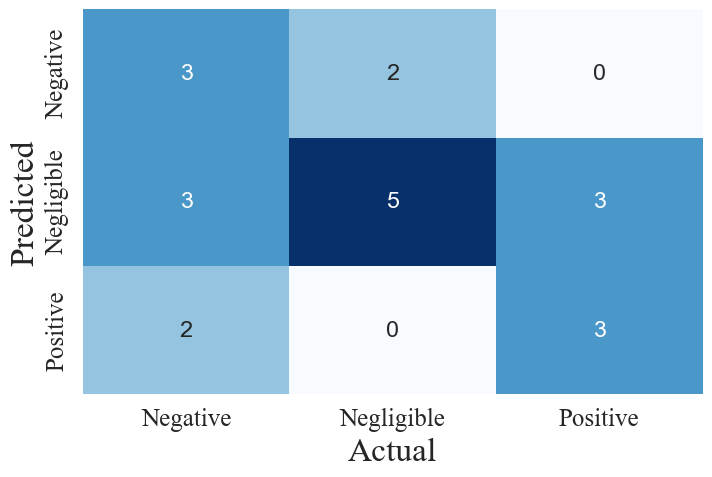

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Define the parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Create an SVM classifier
svm = SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_MOF, y_train_MOF)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_MOF_predicted = best_model.predict(X_test_MOF)
y_train_MOF_predicted = best_model.predict(X_train_MOF)
accuracy = accuracy_score(y_test_MOF, y_test_MOF_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_MOF_predicted, y_test_MOF_predicted))
y_true =  np.concatenate((y_train_MOF, y_test_MOF))
X_all = pd.concat([X_train_MOF, X_test_MOF], axis=0)

test_matrix = confusion_matrix(y_test_MOF, y_test_MOF_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

accuracy = accuracy_score(y_train_MOF, y_train_MOF_predicted)
print("Train Accuracy: ", accuracy)


# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.set(font_scale=1.4)
sns.heatmap(test_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()
fig.savefig('fig/flex_classification_MOF_confusion_matrix.jpg',dpi=500,bbox_inches='tight')

# Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.7948529411764705
Test Accuracy:  0.8095238095238095
[[0 1 1]
 [0 8 0]
 [1 1 9]]
[[ 9  1  1]
 [ 0 47  2]
 [ 1  4 39]]
Train Accuracy:  0.9397590361445783


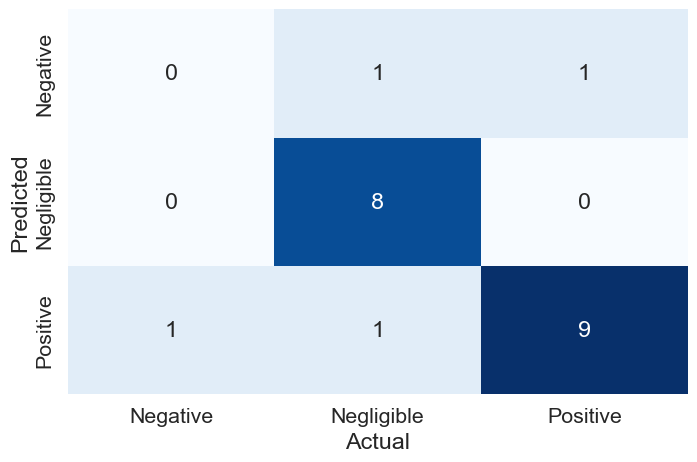

In [54]:
from sklearn.svm import SVC

# Define the parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Create an SVM classifier
svm = SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_adsorbate, y_train_adsorbate)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_adsorbate_predicted = best_model.predict(X_test_adsorbate)
y_train_adsorbate_predicted = best_model.predict(X_train_adsorbate)
accuracy = accuracy_score(y_test_adsorbate, y_test_adsorbate_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_adsorbate_predicted, y_test_adsorbate_predicted))
y_true =  np.concatenate((y_train_adsorbate, y_test_adsorbate))
X_all = pd.concat([X_train_adsorbate, X_test_adsorbate], axis=0)

test_matrix = confusion_matrix(y_test_adsorbate, y_test_adsorbate_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)


accuracy = accuracy_score(y_train_adsorbate, y_train_adsorbate_predicted)
print("Train Accuracy: ", accuracy)


# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.heatmap(test_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()
fig.savefig('fig/flex_classification_adsorbate_confusion_matrix.jpg',dpi=500,bbox_inches='tight')

Best Parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score:  0.713235294117647
Test Accuracy:  0.8095238095238095
[[0 1 1]
 [0 9 2]
 [0 0 8]]
[[ 9  1  1]
 [ 1 43  5]
 [ 0  2 42]]
Train Accuracy:  0.927710843373494


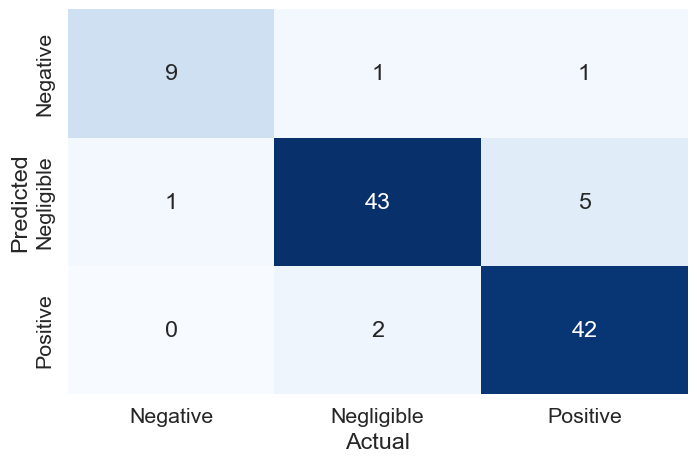

In [55]:
from sklearn.svm import SVC

# Define the parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Create an SVM classifier
svm = SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_predicted = best_model.predict(X_test)
y_train_predicted = best_model.predict(X_train)
accuracy = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_predicted, y_test_predicted))
y_true =  np.concatenate((y_train, y_test))
X_all = pd.concat([X_train, X_test], axis=0)

test_matrix = confusion_matrix(y_test, y_test_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

accuracy = accuracy_score(y_train, y_train_predicted)
print("Train Accuracy: ", accuracy)


# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.heatmap(all_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()
fig.savefig('fig/flex_classification_all_confusion_matrix.jpg',dpi=500,bbox_inches='tight')

### Benchmark: SVM and other classification models

Best Parameters:  {'n_neighbors': 3, 'weights': 'uniform'}
Best Score:  0.7139705882352941
Test Accuracy:  0.8571428571428571
[[ 0  1  1]
 [ 1 10  0]
 [ 0  0  8]]
[[ 4  2  5]
 [ 2 42  5]
 [ 1  2 41]]
Train Accuracy:  0.8313253012048193


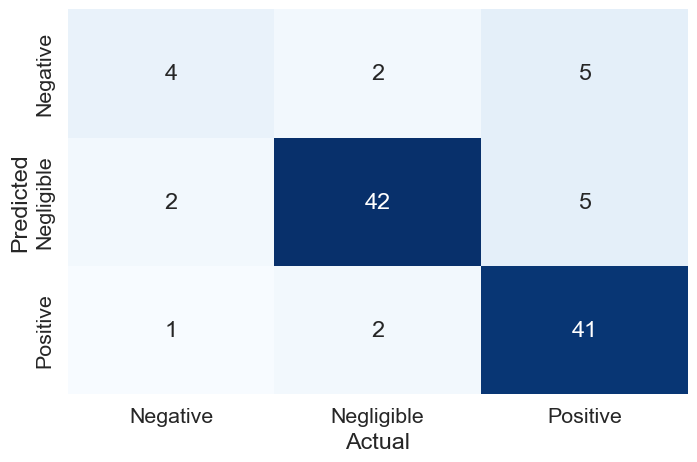

In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for the grid search
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# Create an SVM classifier
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_predicted = best_model.predict(X_test)
y_train_predicted = best_model.predict(X_train)
accuracy = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_predicted, y_test_predicted))
y_true =  np.concatenate((y_train, y_test))
X_all = pd.concat([X_train, X_test], axis=0)

test_matrix = confusion_matrix(y_test, y_test_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

accuracy = accuracy_score(y_train, y_train_predicted)
print("Train Accuracy: ", accuracy)


# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.heatmap(all_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()


Best Parameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  0.7382352941176471
Test Accuracy:  0.8571428571428571
[[ 0  1  1]
 [ 1 10  0]
 [ 0  0  8]]
[[ 5  2  4]
 [ 2 42  5]
 [ 1  2 41]]
Train Accuracy:  0.8433734939759037


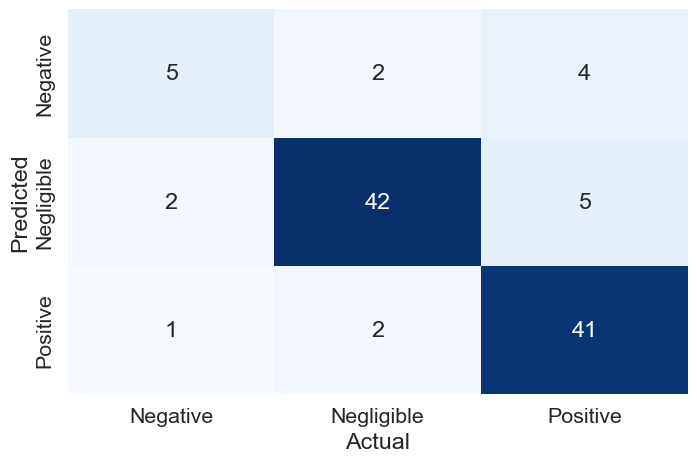

In [57]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}

# Create an SVM classifier
rf = RandomForestClassifier(random_state=0,n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_predicted = best_model.predict(X_test)
y_train_predicted = best_model.predict(X_train)
accuracy = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_predicted, y_test_predicted))
y_true =  np.concatenate((y_train, y_test))
X_all = pd.concat([X_train, X_test], axis=0)

test_matrix = confusion_matrix(y_test, y_test_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

accuracy = accuracy_score(y_train, y_train_predicted)
print("Train Accuracy: ", accuracy)


# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.heatmap(all_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()


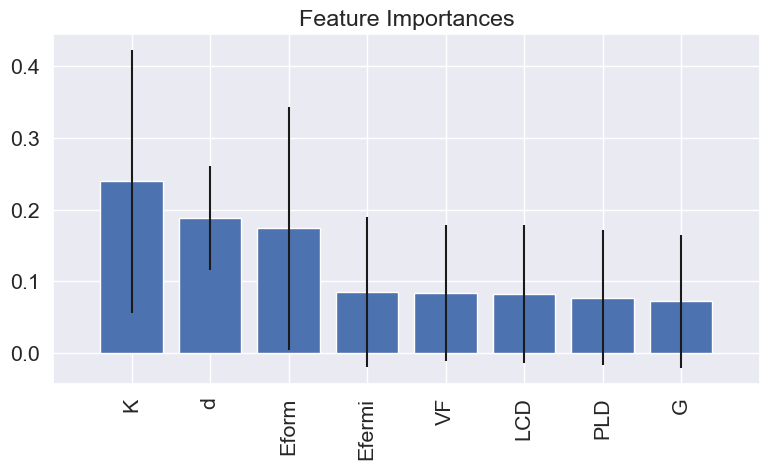

In [58]:
# Get feature importances
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [selected_features[i] for i in indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### Regression using PCA and GPR

In [59]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[4:-1]])

pca = PCA(n_components=10)
pca.fit(normalized_data)
pca_df = pca.transform(normalized_data)

print(pca.explained_variance_ratio_)

from sklearn.decomposition import PCA
import numpy as np

# Obtain the component matrix
component_matrix = pca.components_


[0.40329917 0.15016547 0.11713406 0.05526509 0.04835413 0.04474766
 0.03312042 0.02451816 0.02208833 0.01943799]


In [60]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,GridSearchCV


X, y = pca_df, df['ratio']
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the kernel for the Gaussian process
kernel1,kernel2,kernel3 = RBF(length_scale_bounds=(1e-9,1e9)), WhiteKernel(noise_level_bounds=(1e-9,1e9)) + RBF(length_scale_bounds=(1e-9,1e9)), DotProduct(sigma_0_bounds=(1e-9,1e9))+WhiteKernel(noise_level_bounds=(1e-9,1e9))
# Create the Gaussian Process Regression model
gpr = GaussianProcessRegressor()
# Define hyperparameters to tune
param_grid = {'alpha': [0.01, 0.1, 1, 10], 
              'kernel': [kernel1, kernel2, kernel3],
              }

# Perform k-fold cross-validation with hyperparameter tuning
kfold = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(gpr, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_search.fit(X_train_regression, y_train_regression)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", np.sqrt(-grid_search.best_score_))

best_gpr_model = grid_search.best_estimator_
best_gpr_model.fit(X_train_regression, y_train_regression)
y_test_predict, y_test_predict_std = best_gpr_model.predict(X_test_regression, return_std=True)
y_all_predict, y_all_predict_std = best_gpr_model.predict(X, return_std=True)

/home/zhenzi/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Best Hyperparameters:  {'alpha': 0.1, 'kernel': WhiteKernel(noise_level=1) + RBF(length_scale=1)}
Best Score:  0.5666921987486585


Text(0, 0.5, 'Predicted value')

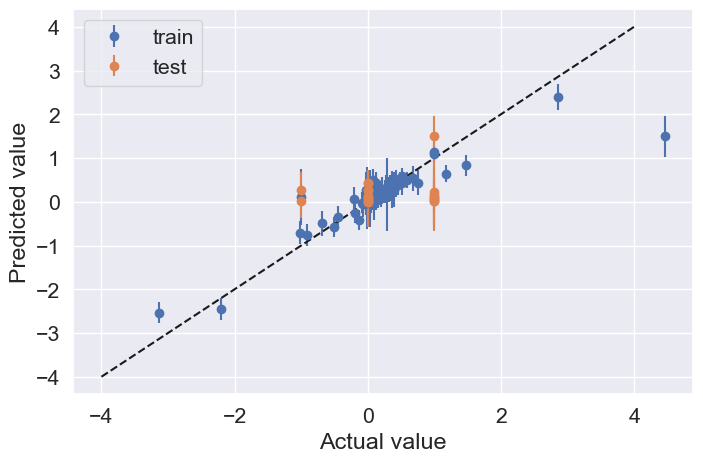

In [61]:
fig, ax = plt.subplots()
ax.errorbar(y, y_all_predict,  yerr = y_all_predict_std, fmt='o', label="train")
ax.errorbar(y_test, y_test_predict, yerr = y_test_predict_std, fmt='o', label="test")
ax.plot([-4,4],[-4,4],color='k',ls='--')
ax.plot([])

ax.legend()
ax.set_xlabel('Actual value')
ax.set_ylabel("Predicted value")

#fig.savefig('fig/flex_regression.jpg',dpi=500,bbox_inches='tight')
#plt.title("Gaussian process regression on noise-free dataset")